In [1]:
# Импорт необходимых библиотек
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import shap

import lightgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna

from sklearn.metrics import classification_report

## Загрузка датасета и деление выборок

In [2]:
# Импорт Датафрейма Volve
df_Volve = pd.read_pickle("DataFrame_Volve_09_09.pkl")
# Импорт Датафрейма Brugge
df_Brugge = pd.read_pickle("DataFrame_Brugge_09_09.pkl")

In [30]:
df_Volve.head(5)

,UWI,well_id,dept_start,dept_end,aug,Флаг,КровЛиния,МКЛ,ПодшЛиния,МПЛ,...,ОМКП,G,S,Am,P,Kp,m,R,Kc,Kt
0,15_9-19 A prefix 1,15_9-19 A,3821.7348,3829.7642,False,5,1,0.1524,1,0.1524,...,0.038462,0.516575,0.028849,0.881334,0.015003,61.090836,0.000051,0.352941,-0.422222,0.000
1,15_9-19 A prefix 2,15_9-19 A,3829.8120,3832.4417,False,1,1,0.3048,1,0.1524,...,0.187500,0.515886,0.046405,0.924564,0.065980,-13.869175,-0.000998,0.312500,2.000000,-3.225
2,15_9-19 A prefix 3,15_9-19 A,3832.5552,3835.6428,False,5,1,0.3048,1,0.0396,...,0.112992,0.511886,0.044135,0.852665,0.047003,-14.192761,-0.000758,0.285714,1.950000,0.000
3,15_9-19 A prefix 4,15_9-19 A,3835.6428,3836.8591,False,8,1,0.1128,1,0.1524,...,0.580052,0.571846,0.094125,0.755718,0.235385,2.835647,0.008597,0.125000,0.000000,9.300
4,15_9-19 A prefix 5,15_9-19 A,3836.9748,3841.9270,False,6,1,0.3048,1,0.7620,...,0.241379,0.524353,0.034002,0.896593,0.029476,35.907033,0.000003,0.322581,-0.111111,0.300


In [4]:
df_Brugge.head(5)

,UWI,well_id,dept_start,dept_end,aug,Флаг,КровЛиния,МКЛ,ПодшЛиния,МПЛ,...,ОМКП,G,S,Am,P,Kp,m,R,Kc,Kt
0,I1 prefix 1,NaN,1702.8063,1704.1898,False,1.0,1,0.355800,1,0.3427,...,1.019708,0.579313,0.146170,0.565823,0.242713,1.146545,-0.012809,0.111111,0.000000,0.000000
1,I1 prefix 2,NaN,1704.8750,1705.9026,False,1.0,1,0.319405,1,0.3425,...,1.809992,0.575357,0.137197,0.539483,0.323278,0.146390,-0.025731,0.166667,0.000000,0.000000
2,I1 prefix 3,NaN,1710.6954,1712.0640,False,1.0,1,0.342600,1,0.3422,...,1.001462,0.565078,0.186271,0.604257,0.316800,0.404649,-0.022567,0.250000,0.000000,-1.750000
3,I1 prefix 4,NaN,1713.4321,1725.5634,False,2.0,1,0.328178,1,0.4271,...,0.883573,0.526339,0.109480,0.501396,0.040367,11.389345,-0.000038,0.150000,-2.423529,1.811765
4,I1 prefix 5,NaN,1740.0031,1756.1372,False,3.0,1,0.585300,1,0.2916,...,0.235113,0.490967,0.113019,0.770128,0.030875,-12.921154,-0.000062,0.168067,-1.305263,1.105263


In [31]:
# Перекодировка кодов фаций Volve, чтобы не было пересечения с кодами фаций Brugge
for i in range(df_Volve.shape[0]):
    if df_Volve["Флаг"][i] == 5:
        df_Volve["Флаг"][i] = 5.0
    elif df_Volve["Флаг"][i] == 3:
        df_Volve["Флаг"][i] = 6.0
    elif df_Volve["Флаг"][i] == 6:
        df_Volve["Флаг"][i] = 7.0
    elif df_Volve["Флаг"][i] == 2:
        df_Volve["Флаг"][i] = 8.0
    elif df_Volve["Флаг"][i] == 1:
        df_Volve["Флаг"][i] = 9.0
    elif df_Volve["Флаг"][i] == 7:
        df_Volve["Флаг"][i] = 10.0
    elif df_Volve["Флаг"][i] == 8:
        df_Volve["Флаг"][i] = 11.0

C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\347025692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Volve["Флаг"][i] = 5.0
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\347025692.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Volve["Флаг"][i] = 9.0
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\347025692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Volve["Флаг"][i] = 5.0
C:\Users\nik_c\AppData\L

In [32]:
# Создание в датафрейме Brugge столбца well_id
for i in range(df_Brugge.shape[0]):
    if pd.isnull(df_Brugge["well_id"][i]):
        df_Brugge["well_id"][i] = df_Brugge["UWI"][i].split()[0]

C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\1956383562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Brugge["well_id"][i] = df_Brugge["UWI"][i].split()[0]
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\1956383562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Brugge["well_id"][i] = df_Brugge["UWI"][i].split()[0]
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\1956383562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [33]:
# Объедение датафреймов Brugge и Volve
df = pd.concat([df_Volve, df_Brugge])
df.reset_index(inplace=True)
df = df.drop("index", axis=1) 

In [34]:
# Удаление тестовых скважин (отложенная выборка)
well_Volve = "15_9-19 BT2"
well_Brugge = "P5"

In [35]:
# Создание в словаре 11 Датафреймов (для обучающей и тестовой выборки), в каждом из которых данные только с определенной фацией
# В этом словаре исключены тестовые скважины Brugge и Volve, т.к. они идут на итоговую проверку модели

dict_df_facies = {1 : np.NaN, 2 : np.NaN, 3 : np.NaN, 4 : np.NaN,
                            5 : np.NaN, 6 : np.NaN, 7 : np.NaN, 8 : np.NaN,
                            9 : np.NaN, 10 : np.NaN, 
                            11 : np.NaN
                            }

for i in dict_df_facies:
    # dict_df_facies[i] = Volve_And_Brugge[(Volve_And_Brugge["well_id"] != well_Brugge) & (Volve_And_Brugge["well_id"] != well_Volve)][Volve_And_Brugge["Флаг"] == i]
    dict_df_facies[i] = df[( ~ df['well_id'].isin([well_Brugge])) & ( ~ df['well_id'].isin([well_Volve]))][df["Флаг"] == i]

C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\982616554.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dict_df_facies[i] = df[( ~ df['well_id'].isin([well_Brugge])) & ( ~ df['well_id'].isin([well_Volve]))][df["Флаг"] == i]
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\982616554.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dict_df_facies[i] = df[( ~ df['well_id'].isin([well_Brugge])) & ( ~ df['well_id'].isin([well_Volve]))][df["Флаг"] == i]
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\982616554.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dict_df_facies[i] = df[( ~ df['well_id'].isin([well_Brugge])) & ( ~ df['well_id'].isin([well_Volve]))][df["Флаг"] == i]
C:\Users\nik_c\AppData\Local\Temp\ipykernel_31868\982616554.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dict_df_facies[i] = df[( ~ df['well_id'].isin([well_Brugge])

In [36]:
# столбцы в X (Фичи)
X_columns = df.columns[6:]
X_columns

Index(['КровЛиния', 'МКЛ', 'ПодшЛиния', 'МПЛ', 'ДКЛ', 'ДПЛ', 'УКЛ', 'УПЛ',
       'УКП', 'ОКЛ', 'СВТВХ', 'ДУМЗ', 'СВТВЗ', 'ДУВЗ', 'БЛ', 'ДБЛ', 'МБЛ',
       'УБЛ', 'УБК', 'УБП', 'ОУКБ', 'ОУПБ', 'ОМКП', 'G', 'S', 'Am', 'P', 'Kp',
       'm', 'R', 'Kc', 'Kt'],
      dtype='object')

In [37]:
# Матрица корреляции
corr = df[X_columns].corr()
corr.style.background_gradient(cmap = 'coolwarm')

C:\Users\nik_c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\io\formats\style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\nik_c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\io\formats\style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,КровЛиния,МКЛ,ПодшЛиния,МПЛ,ДКЛ,ДПЛ,УКЛ,УПЛ,УКП,ОКЛ,СВТВХ,ДУМЗ,СВТВЗ,ДУВЗ,БЛ,ДБЛ,МБЛ,УБЛ,УБК,УБП,ОУКБ,ОУПБ,ОМКП,G,S,Am,P,Kp,m,R,Kc,Kt
КровЛиния,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
МКЛ,nan,1.000000,nan,0.828019,0.430710,0.230416,0.223602,0.044783,0.079324,-0.080655,0.376102,-0.099857,0.123636,0.099857,-0.031493,0.080343,0.370929,0.163369,0.002287,0.001808,-0.022019,0.000153,0.069702,-0.088039,-0.135306,0.040032,-0.128519,0.088374,0.032675,-0.190959,0.047682,0.018618
ПодшЛиния,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
МПЛ,nan,0.828019,nan,1.000000,0.258228,0.468246,0.186776,0.077074,0.083705,-0.080507,0.374538,-0.091238,0.163024,0.091238,0.004210,0.052501,0.275078,0.162360,0.034773,0.043709,-0.021661,0.000289,0.101909,-0.046838,-0.127445,0.033261,-0.132469,0.067881,0.038725,-0.211581,0.009325,0.004350
ДКЛ,nan,0.430710,nan,0.258228,1.000000,0.524196,0.220680,-0.100193,0.206676,-0.423256,0.016639,-0.076493,0.086014,0.076493,-0.279634,-0.032390,-0.174211,0.221431,-0.173967,-0.222054,-0.059052,-0.040721,0.325854,0.222553,-0.135181,-0.173645,0.227706,0.036282,-0.010652,-0.168985,0.071302,0.060514
ДПЛ,nan,0.230416,nan,0.468246,0.524196,1.000000,0.176407,-0.072815,0.207285,-0.408588,0.044691,0.024572,0.159130,-0.024572,-0.186606,-0.024498,-0.191684,0.209532,-0.102634,-0.104341,-0.046439,-0.022421,0.335307,0.309786,-0.173088,-0.119499,0.179223,0.073616,0.048262,-0.202917,-0.040606,-0.003258
УКЛ,nan,0.223602,nan,0.186776,0.220680,0.176407,1.000000,-0.151128,0.640410,-0.000680,0.147706,-0.065116,0.110822,0.065116,-0.148933,-0.188485,-0.002325,0.193081,0.224447,-0.036972,-0.095671,0.030881,0.123319,-0.022622,-0.169677,-0.138454,-0.094398,-0.004303,0.232317,-0.151572,0.043744,0.221776
УПЛ,nan,0.044783,nan,0.077074,-0.100193,-0.072815,-0.151128,1.000000,-0.485251,0.085968,0.068871,-0.047080,0.259401,0.047080,0.267702,0.267943,0.062949,-0.029447,0.121312,0.042327,0.085537,-0.001392,-0.134117,0.098483,0.190233,0.284014,0.070359,-0.008649,-0.321686,0.170827,-0.051003,-0.071548
УКП,nan,0.079324,nan,0.083705,0.206676,0.207285,0.640410,-0.485251,1.000000,-0.106267,0.025180,-0.054227,-0.090871,0.054227,-0.359687,-0.323146,-0.041127,0.214232,0.053192,-0.010652,-0.172689,0.017806,0.192027,-0.118248,-0.194379,-0.307555,-0.095827,0.008159,0.425162,-0.292011,0.131751,0.259351
ОКЛ,nan,-0.080655,nan,-0.080507,-0.423256,-0.408588,-0.000680,0.085968,-0.106267,1.000000,0.097710,0.065691,-0.098840,-0.065691,0.178291,-0.270180,0.190892,-0.166912,0.163862,0.107778,-0.002044,-0.013531,-0.208276,-0.273452,0.149217,-0.047208,-0.342695,-0.010716,0.065613,0.075956,0.007848,0.055694


In [38]:
# Удаление незначащих столбцов после корреляционного анализа
df = df.drop(["КровЛиния", "ПодшЛиния", 
              "БЛ"
              ]
              , axis=1)
df.reset_index(inplace=True)
df = df.drop("index", axis=1)

# Столбцы в X (Фичи)
X_columns = df.columns[6:]
X_columns

Index(['МКЛ', 'МПЛ', 'ДКЛ', 'ДПЛ', 'УКЛ', 'УПЛ', 'УКП', 'ОКЛ', 'СВТВХ', 'ДУМЗ',
       'СВТВЗ', 'ДУВЗ', 'ДБЛ', 'МБЛ', 'УБЛ', 'УБК', 'УБП', 'ОУКБ', 'ОУПБ',
       'ОМКП', 'G', 'S', 'Am', 'P', 'Kp', 'm', 'R', 'Kc', 'Kt'],
      dtype='object')

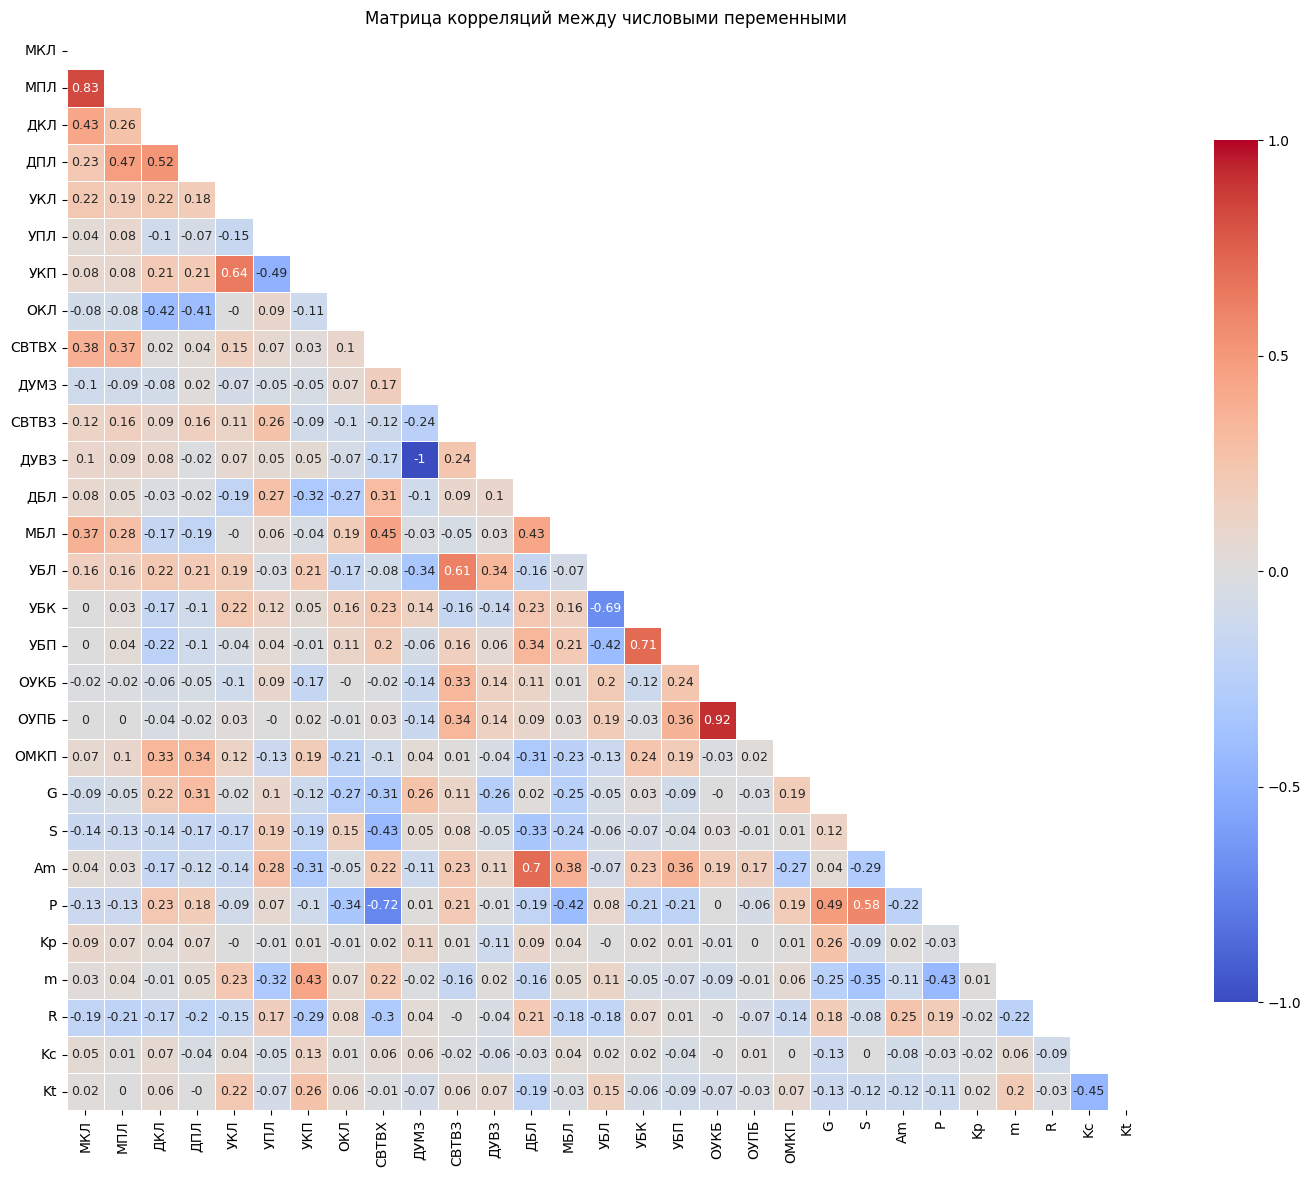

In [39]:
# Итоговая матрица корреляции

correlation_matrix = df[X_columns].corr().round(2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 9}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


In [14]:
# Сохранение массива для построения гистограмм
# df.to_pickle("Data_For_Hist.pkl")

In [40]:
# Деление выборок на обучение, валидацию и тест
df_X_train = df[X_columns].iloc[0:0]
df_X_test = df[X_columns].iloc[0:0]
df_X_valid = df[X_columns].iloc[0:0]

df_y_train = df["Флаг"].iloc[0:0]
df_y_test = df["Флаг"].iloc[0:0]
df_y_valid = df["Флаг"].iloc[0:0]

In [41]:
# Создание тестовой выборки, скважины Brugge и Volve
X_real = df[(df["well_id"] == well_Brugge) | (df["well_id"] == well_Volve)][X_columns]
Y_real = df[(df["well_id"] == well_Brugge) | (df["well_id"] == well_Volve)]["Флаг"]

In [42]:
# 70% от всей выборки (кроме тестовых скважин) идут на обучение, 30% на валидацию
for i in dict_df_facies:
    X_train, X_test, y_train, y_test = train_test_split(dict_df_facies[i][X_columns], dict_df_facies[i]["Флаг"], test_size=0.3, random_state=42)
    
    df_X_train = pd.concat([df_X_train, X_train])
    df_X_test = pd.concat([df_X_test, X_test])
    df_y_train = pd.concat([df_y_train, y_train])
    df_y_test = pd.concat([df_y_test, y_test])

X_train = df_X_train.copy(deep = True)
X_test = df_X_test.copy(deep = True)
Y_train = df_y_train.copy(deep = True)
Y_test = df_y_test.copy(deep = True)

In [43]:
len(X_train), len(X_test)

(848, 371)

# Подбор гиперпараметров Optuna

In [19]:
# # Оптимизация TPE

# def objective(trial):
#     params = {
#         "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#         "max_depth": trial.suggest_int("max_depth", 4, 12),
#         "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#     }

#     model = LGBMClassifier(**params, verbosity=-1)
#     model.fit(X_train, Y_train)
#     predictions = model.predict(X_real)
#     f1 = f1_score(Y_test, predictions, average='micro')
#     return f1

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=120)

# print('Best hyperparameters:', study.best_params)
# print('Best f1:', study.best_value)

In [20]:
# # Оптимизация TPE

# def objective(trial):
#     params = {
#         # "boosting_type": "goss",
#         "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#         "max_depth": trial.suggest_int("max_depth", 5, 12),
#         "n_estimators": trial.suggest_int("n_estimators", 400, 1000),

#         'num_leaves': trial.suggest_int('num_leaves', 2, 512),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.2, 0.951), #   'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 0.95),
#         'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),

#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#     }

#     model = LGBMClassifier(**params, verbosity=-1)
#     model.fit(X_train, Y_train)
#     predictions = model.predict(X_real)
#     f1 = f1_score(Y_test, predictions, average='micro')
#     return f1

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=120)

# print('Best hyperparameters:', study.best_params)
# print('Best f1:', study.best_value)

In [21]:
# # Оптимизация TPE

# def objective(trial):
#     params = {
#         "boosting_type": "goss",
#         # "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
#         # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#         "learning_rate": 0.01,
#         "max_depth": trial.suggest_int("max_depth", 5, 12),
#         "n_estimators": trial.suggest_int("n_estimators", 400, 1200),
 
#         # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.2, 0.951), #   'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1),
#         # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.2, 0.95),
#         # 'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),

#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 512),

#         # "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#     }

#     model = LGBMClassifier(**params, verbosity=-1)
#     model.fit(X_train, Y_train)
#     predictions = model.predict(X_real)
#     f1 = f1_score(Y_test, predictions, average='macro')
#     return f1

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)

# print('Best hyperparameters:', study.best_params)
# print('Best f1:', study.best_value)

In [44]:
# Обучение модели с одним из лучших наборов гиперпараметров, полученном при оптимизации
classifier = LGBMClassifier(boosting_type='goss', max_depth=12, num_leaves=132, min_child_samples=1, n_estimators=803, learning_rate=0.01)
classifier.fit(X_train, Y_train)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6799
[LightGBM] [Info] Number of data points in the train set: 848, number of used features: 29
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.276973
[LightGBM] [Info] Start training from score -2.157913
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training

LGBMClassifier(boosting_type='goss', learning_rate=0.01, max_depth=12,
               min_child_samples=1, n_estimators=803, num_leaves=132)

# Результаты работы на обучающей, валидационной и тестовой выборках

In [45]:
code_facies_Brugge_Volve = {1 : "Channel Sand", 2 : "Lower Shoreface (Brugge)", 3 : "Barrier Sands", 4 : "Upper Shoreface (Brugge)",
                            5 : "Tidal Bar", 6 : "Mouthbar", 7 : "Tidal Channel", 8 : "Lower Shoreface (Volve)", 9 : "Upper Shoreface (Volve)", 10 : "Marsh", 
                            11 : "Offshore"
                            }

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        87
         2.0       1.00      1.00      1.00        98
         3.0       1.00      1.00      1.00        53
         4.0       1.00      1.00      1.00        75
         5.0       1.00      1.00      1.00        81
         6.0       1.00      1.00      1.00        79
         7.0       1.00      1.00      1.00        80
         8.0       1.00      1.00      1.00        74
         9.0       1.00      1.00      1.00        74
        10.0       1.00      1.00      1.00        74
        11.0       1.00      1.00      1.00        73

    accuracy                           1.00       848
   macro avg       1.00      1.00      1.00       848
weighted avg       1.00      

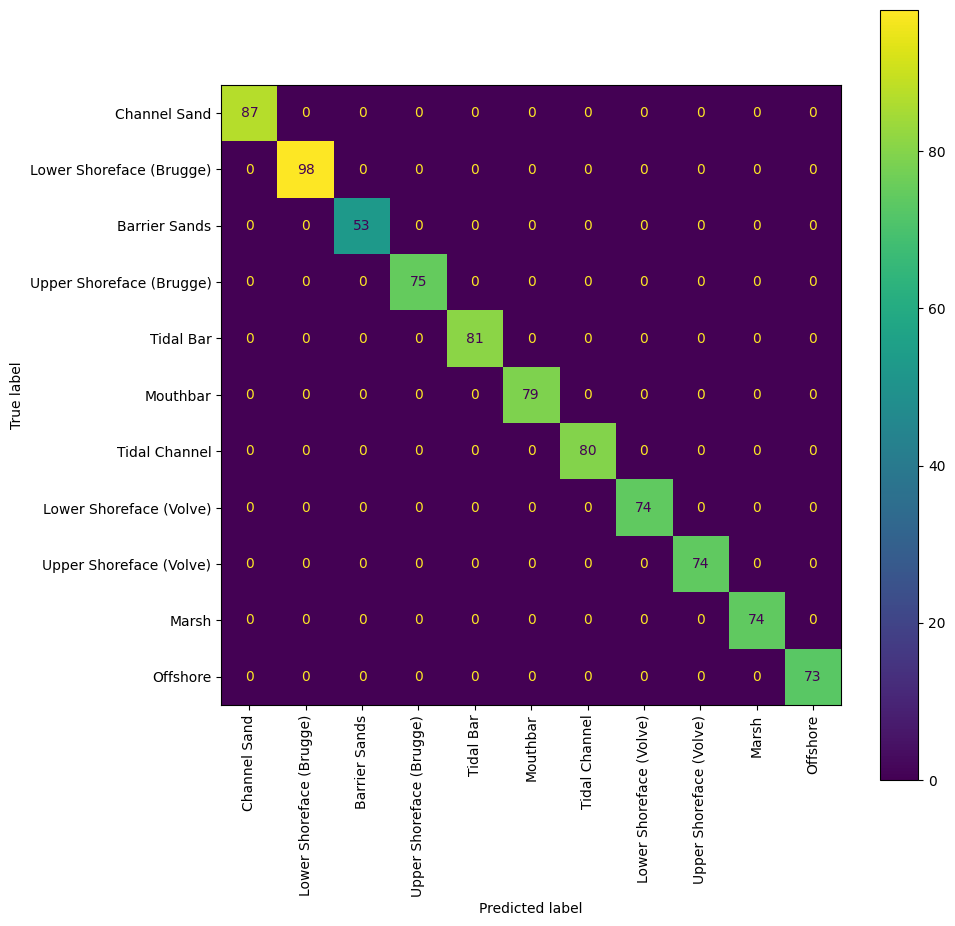

In [46]:
# Обучающая выборка
Y_Predict_Train = classifier.predict(X_train) 

plt.rcParams["figure.figsize"] = (10,10) 
disp = ConfusionMatrixDisplay.from_predictions(Y_train, Y_Predict_Train, 
                              display_labels= code_facies_Brugge_Volve.values(), 
                              xticks_rotation='vertical'
                              )
print(classification_report(Y_train, Y_Predict_Train))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
              precision    recall  f1-score   support

         1.0       0.92      0.92      0.92        38
         2.0       0.74      0.74      0.74        43
         3.0       0.71      0.50      0.59        24
         4.0       0.66      0.76      0.70        33
         5.0       0.78      0.60      0.68        35
         6.0       0.60      0.62      0.61        34
         7.0       0.68      0.77      0.72        35
         8.0       0.83      0.75      0.79        32
         9.0       0.62      0.61      0.62        33
        10.0       0.82      0.97      0.89        32
        11.0       0.88      0.94      0.91        32

    accuracy                           0.75       371
   macro avg       0.75      0.74      0.74       371
weighted avg       0.75      

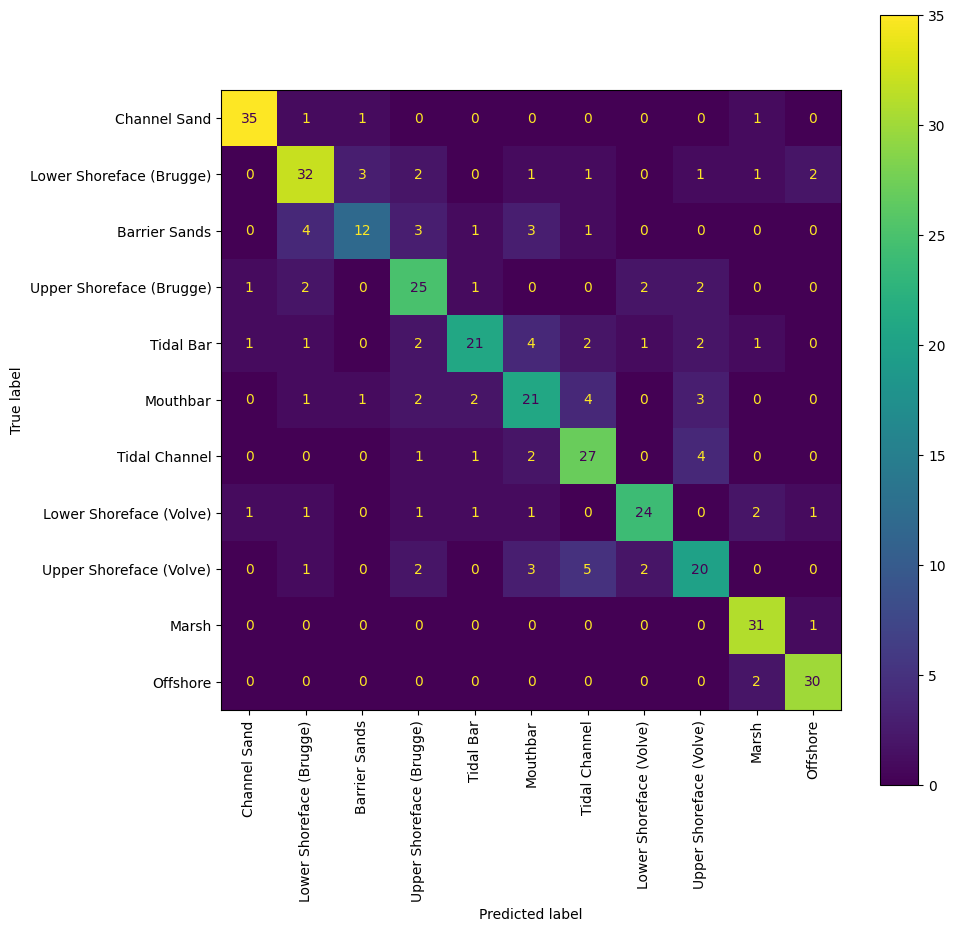

In [47]:
# Валидационная выборка
Y_Predict_Test = classifier.predict(X_test) #Предсказываем Y по X, применение сети

plt.rcParams["figure.figsize"] = (10,10) 
disp = ConfusionMatrixDisplay.from_predictions(Y_test, Y_Predict_Test, display_labels= code_facies_Brugge_Volve.values(), 
                              xticks_rotation='vertical'
                              )
print(classification_report(Y_test, Y_Predict_Test))
all_f1 = (f1_score(Y_test, Y_Predict_Test, average=None))
print(all_f1.round(2))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


C:\Users\nik_c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nik_c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nik_c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         2.0       1.00      1.00      1.00         1
         3.0       0.50      1.00      0.67         1
         4.0       1.00      1.00      1.00         1
         5.0       1.00      0.33      0.50         3
         6.0       0.75      1.00      0.86         3
         7.0       0.60      1.00      0.75         3
         8.0       1.00      0.67      0.80         3
         9.0       0.00      0.00      0.00         1
        10.0       1.00      1.00      1.00         1
        11.0       0.00      0.00      0.00         1

    accuracy                           0.75        20
   macro avg       0.71      0.73      0.69        20
weighted avg       0.78      0.75      0.72        20

[1.   1.   0.67 1.   0.5  0.86 0.75 0.8  0.   1.   0.  ]


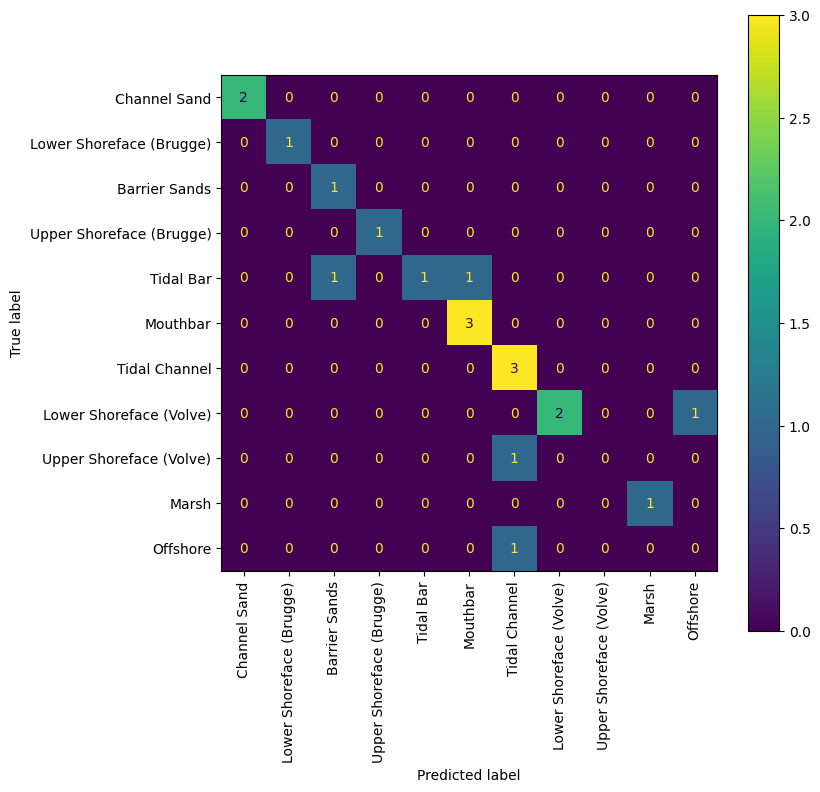

In [48]:
# Тестовая выборка
Y_Predict_Real = classifier.predict(X_real) #Предсказываем Y по X, применение сети

plt.rcParams["figure.figsize"] = (8,8) 
# cm = confusion_matrix(Y_train, Y_Predict_Train)
disp = ConfusionMatrixDisplay.from_predictions(Y_real, Y_Predict_Real, display_labels= code_facies_Brugge_Volve.values(), 
                              xticks_rotation='vertical'
                              )
print(classification_report(Y_real, Y_Predict_Real))
all_f1 = (f1_score(Y_real, Y_Predict_Real, average=None))
print(all_f1.round(2))

In [ ]:
# Таблица с прогнозируемыми вероятностями фаций, которая затем будет подвергаться калибровке
Y_predict_valid = classifier.predict_proba(X_real)
df_prob_facies = pd.DataFrame(Y_predict_valid, columns=[i for i in range(1, 12)])
df_prob_facies = df_prob_facies.astype(float).round(3)
Y_real_ = Y_real.reset_index(inplace = False)
Y_real_.drop("index", axis=1, inplace = True)
Prob = pd.concat([Y_real_, df_prob_facies], axis=1)
Prob.reset_index(inplace=True)
Prob.drop("index", axis=1,inplace=True) 
Prob

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


,Флаг,1,2,3,4,5,6,7,8,9,10,11
0,7.0,0.000,0.000,0.000,0.000,0.000,0.011,0.988,0.000,0.000,0.000,0.000
1,5.0,0.005,0.073,0.012,0.007,0.065,0.674,0.055,0.012,0.089,0.006,0.004
2,8.0,0.006,0.055,0.018,0.007,0.020,0.048,0.005,0.821,0.008,0.005,0.007
3,9.0,0.006,0.003,0.002,0.139,0.203,0.054,0.573,0.008,0.007,0.002,0.003
4,8.0,0.005,0.021,0.004,0.014,0.011,0.011,0.005,0.060,0.008,0.062,0.799
5,5.0,0.200,0.131,0.282,0.033,0.131,0.078,0.025,0.025,0.064,0.015,0.015
6,11.0,0.000,0.000,0.000,0.013,0.005,0.000,0.978,0.000,0.000,0.003,0.000
7,7.0,0.005,0.048,0.027,0.006,0.126,0.255,0.508,0.005,0.012,0.004,0.004
8,6.0,0.005,0.101,0.007,0.007,0.030,0.459,0.004,0.365,0.008,0.007,0.007
9,7.0,0.102,0.028,0.012,0.001,0.017,0.415,0.422,0.001,0.002,0.001,0.001


# Анализ значимости признаков

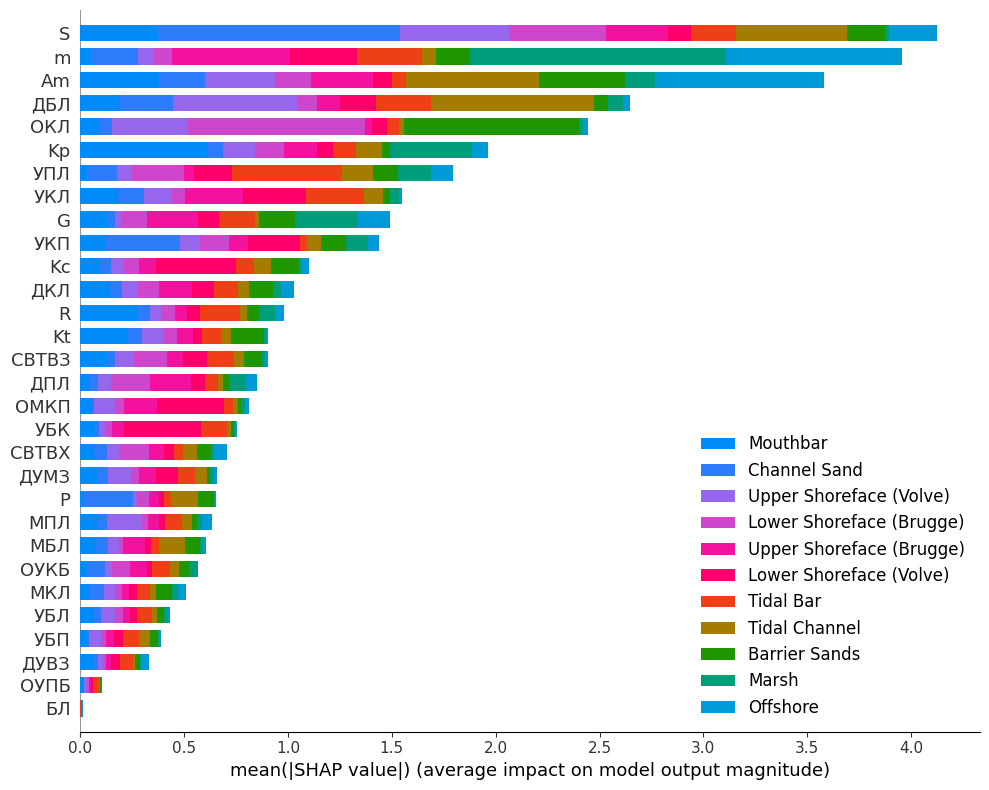

In [28]:
# Для валидационной выборки
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_test)

fig = shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train.columns,
    plot_type="bar",
    max_display = 30,
    # class_names=classifier.classes_
    class_names=list(code_facies_Brugge_Volve.values()), # Переименовали как надо
    plot_size=[10,8],
    show = False
)
plt.savefig('fig_tes1.svg'
            # , bbox_inches='tight',dpi=100
            )

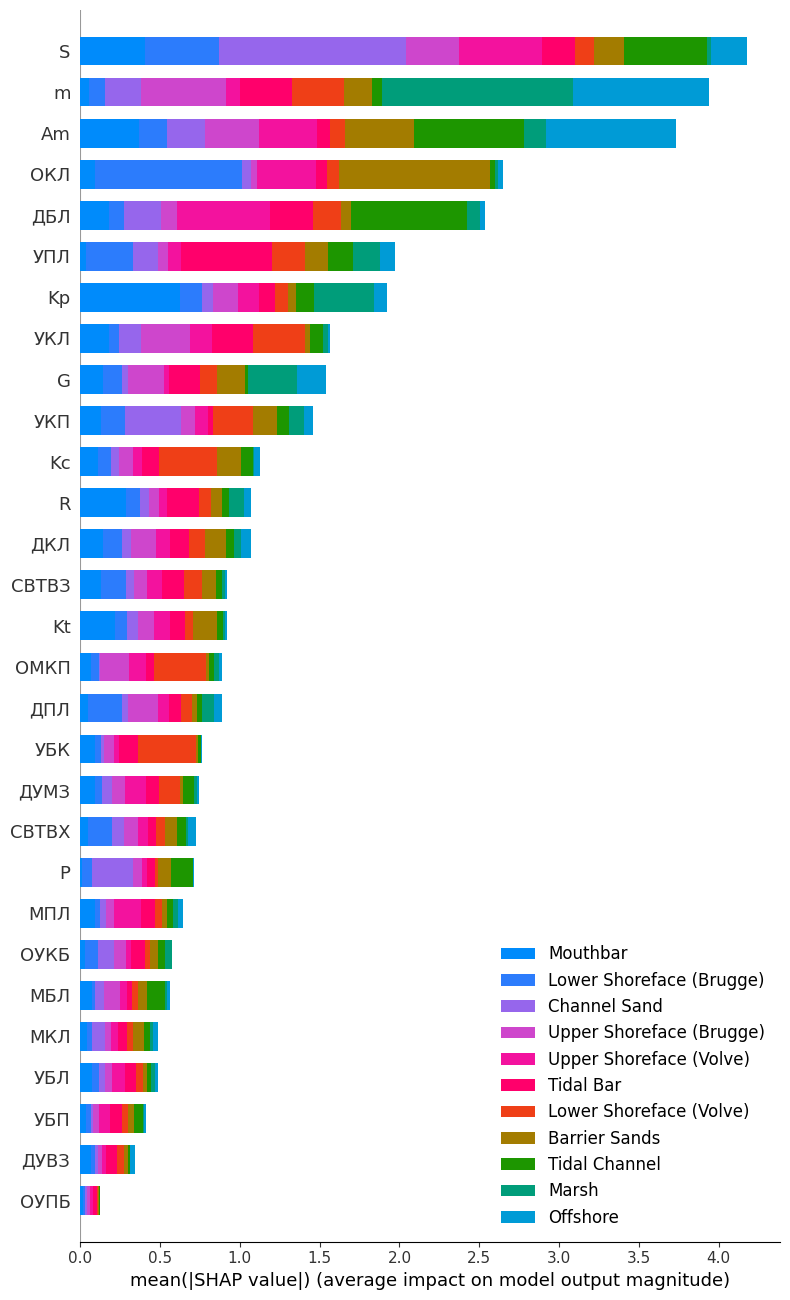

In [ ]:
# Для обучающей выборки
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_train)

shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=X_train.columns,
    plot_type="bar",
    max_display = 30,
    # class_names=classifier.classes_
    class_names=list(code_facies_Brugge_Volve.values()), # Переименовали как надо
    # size = (10,10)
)

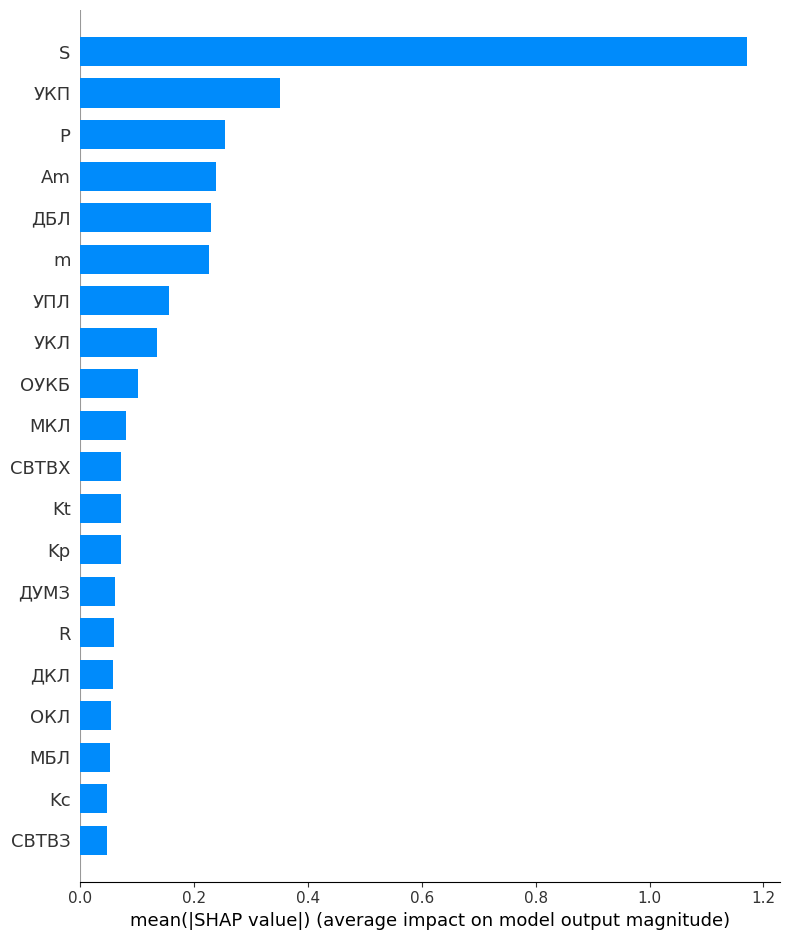

In [ ]:
shap.summary_plot(shap_values[:, :, 0], X_train, plot_type="bar") # Для нулевой фации

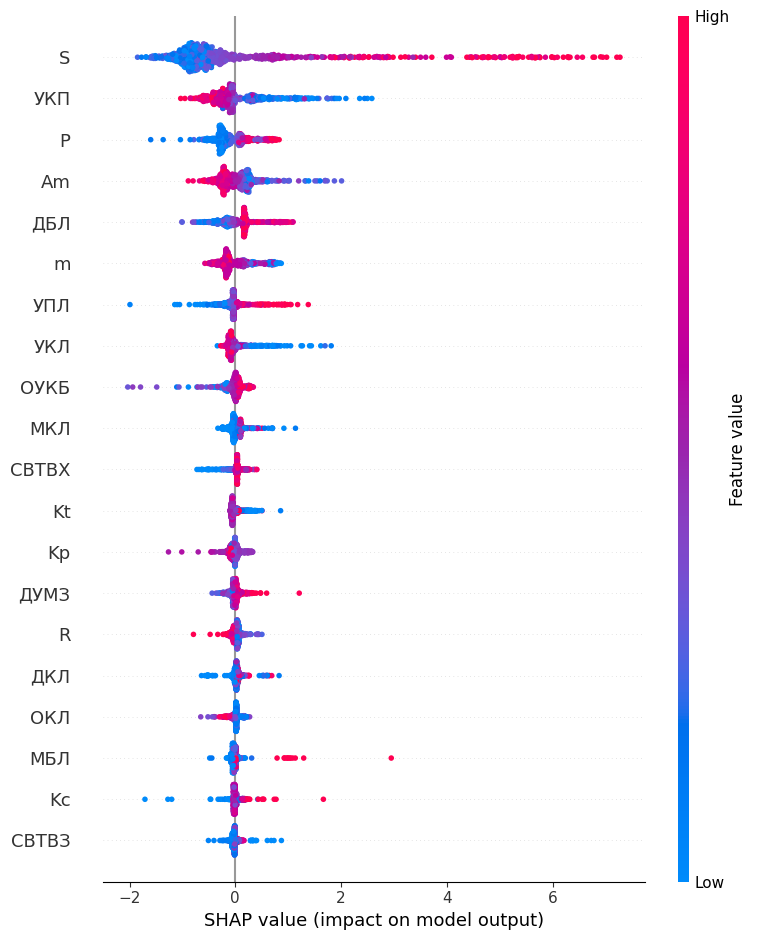

In [ ]:
shap.summary_plot(shap_values[:, :, 0], X_train) # Для нулевой фации

In [ ]:
# Создать словарь со средним шап по фациям
d = {}
for x in range(11):
    d["mean_{0}".format(x)] = np.mean(np.abs(shap_values.values[:,:,x]),axis=0)

In [ ]:
# mean_0 = np.mean(np.abs(shap_values.values[:,:,0]),axis=0)
# mean_1 = np.mean(np.abs(shap_values.values[:,:,1]),axis=0)
# mean_2 = np.mean(np.abs(shap_values.values[:,:,2]),axis=0)

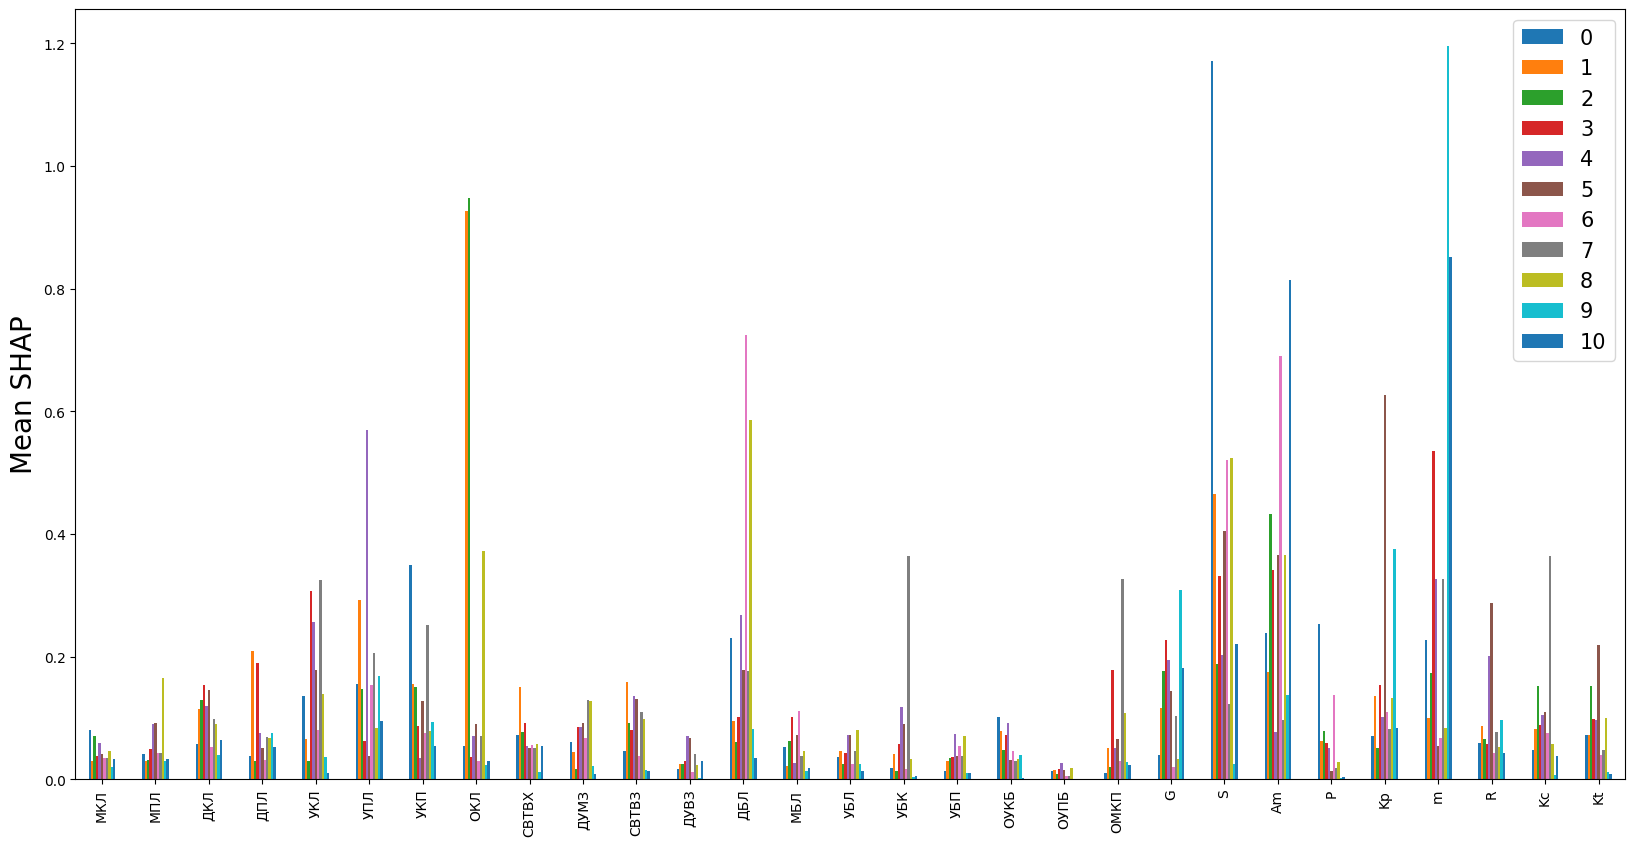

In [ ]:
# calculate mean SHAP values for each class

df = pd.DataFrame({'0':d.get('mean_0'),'1':d.get('mean_1'),'2':d.get('mean_2'),
                   '3':d.get('mean_3'),'4':d.get('mean_4'),'5':d.get('mean_5'),
                   '6':d.get('mean_6'),'7':d.get('mean_7'),'8':d.get('mean_8'),
                   '9':d.get('mean_9'),'10':d.get('mean_10')})

# df = pd.DataFrame({'0':mean_0,'1':mean_1,'2':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 20)
ax.set_xticklabels(X_train.columns,rotation=90,size=10)
ax.legend(fontsize=15)

# Последовательное удаление фичей

In [ ]:
classifier = LGBMClassifier(boosting_type='goss', max_depth=12, num_leaves=132, min_child_samples=1, n_estimators=803, learning_rate=0.01,verbosity=-1)

In [ ]:
#объедение ДФ Brugge и Volve
df = pd.concat([df_Volve, df_Brugge])
df.reset_index(inplace=True)
df = df.drop("index", axis=1) 
#удаление столбцов после корреляционного анализа
df = df.drop(["КровЛиния", "ПодшЛиния", 
            #   "БЛ" 
              ], 
              axis=1)
df.reset_index(inplace=True)
df = df.drop("index", axis=1)
# столбцы в X
X_columns = df.columns[6:]

df_X_train = df[X_columns].iloc[0:0]
df_X_test = df[X_columns].iloc[0:0]
df_X_valid = df[X_columns].iloc[0:0]

df_y_train = df["Флаг"].iloc[0:0]
df_y_test = df["Флаг"].iloc[0:0]
df_y_valid = df["Флаг"].iloc[0:0]
# создание валидационной выборки, скважины Brugge и Volve
X_real = df[(df["well_id"] == well_Brugge) | (df["well_id"] == well_Volve)][X_columns]
Y_real = df[(df["well_id"] == well_Brugge) | (df["well_id"] == well_Volve)]["Флаг"]
# 70% от всей выборки (валидационных скважин) идут на обучение, 30 % на тест

for i in dict_df_facies:
    X_train, X_test, y_train, y_test = train_test_split(dict_df_facies[i][X_columns], dict_df_facies[i]["Флаг"], test_size=0.3, random_state=42)
    
    df_X_train = pd.concat([df_X_train, X_train])
    df_X_test = pd.concat([df_X_test, X_test])
    df_y_train = pd.concat([df_y_train, y_train])
    df_y_test = pd.concat([df_y_test, y_test])

X_train = df_X_train.copy(deep = True)
X_test = df_X_test.copy(deep = True)
Y_train = df_y_train.copy(deep = True)
Y_test = df_y_test.copy(deep = True)

In [ ]:
# Словарь для последовательного удаления влияющих фичей (от наименее значимых к наиболее значимым)
drop_features = [["БЛ"], ["ОУПБ"], ["ДУВЗ"], ["УПБ"],  ["УБЛ"], ["МКЛ"], ["ОУКБ"], ["МБЛ"], 
                 ["МПЛ"], ["ДУМЗ"], ["СВТВХ"],
                 ["P"], ["УБК"], ["ДПЛ"], ["ОМКП"], ["Kt"], ["СВТВЗ"], ["R"], ["ДКЛ"], ["Kc"], 
                  ["УКП"], ["G"],["УКЛ"],["УПЛ"],["Kp"],["ОКЛ"],
                  ["ДБЛ"],["Am"],["m"],
                ]

In [ ]:
for i, item in enumerate(drop_features):
      X_train.drop(item, axis=1, inplace=True)
      X_test.drop(item, axis=1, inplace=True)
      X_real.drop(item, axis=1, inplace=True)

      classifier.fit(X_train, Y_train)

      Y_Predict_Real = classifier.predict(X_real) #Предсказываем Y по X, применение сети
      Y_Predict_Test = classifier.predict(X_test) #Предсказываем Y по X, применение сети

      print(f'Удалены Фичи {item}\n',
            "TEST : ",classification_report(Y_test, Y_Predict_Test),'\n',
            "REAL : ",classification_report(Y_real, Y_Predict_Real))